<a href="https://colab.research.google.com/github/RautRitesh/langgraph/blob/main/Langgraph_with_MessagesState.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install langchain langgraph langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AnyMessage

In [3]:
from google.colab import userdata
api_key=userdata.get('groq_api_key')

In [ ]:
llm=ChatGroq(model="openai/gpt-oss-20b", api_key=api_key)

In [ ]:
class MessagesState(TypedDict):
  messages:Annotated[list[AnyMessage], add_messages]

In [ ]:
def function1(state:MessagesState):
    message=state["messages"]
    print(message)
    print("hello")
    result=llm.invoke(message)
    return {"messages":[result.content]}



In [ ]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",function1)
workflow.add_edge(START,"chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

In [ ]:
from IPython.display import Image,display

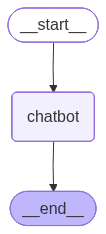

In [ ]:
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [ ]:
output=app.invoke({"messages":["What is Langgraph in 2 sentences?"]})

[HumanMessage(content='What is Langgraph in 2 sentences?', additional_kwargs={}, response_metadata={}, id='4395a290-d75f-48f2-8644-4314e8aab1fe')]
hello


In [ ]:
response=output["messages"][-1].content
print(response)

LangGraph is a framework that lets developers build and orchestrate language‑model pipelines as directed graphs, where each node represents a processing step and edges encode control flow. By managing state and context across nodes, it enables dynamic, reusable, and testable LLM‑driven applications.


##Adding Tool to our Agent, so that it can use the tools also

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage
from typing import TypedDict, Literal, Annotated
from langgraph.graph import StateGraph, MessagesState , add_messages, START, END
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode

In [ ]:
class MessagesState(TypedDict):
  messages:Annotated[list[AnyMessage], add_messages]

In [ ]:
llm=ChatGroq(model="openai/gpt-oss-20b", api_key=api_key)

In [ ]:
@tool
def search(query:str):
  """This is the tool that will provide information about weather"""
  if 'nepal' in query.lower() or 'nep' in query.lower() or 'np' in query.lower():
    return "The weather is cold with days warm"
  else:
    return "The weather is extremely cold"

In [ ]:
search.invoke("Nepal weather is?")

'The weather is cold with days warm'

In [ ]:
tools=[search]

In [ ]:
llm_with_tools=llm.bind_tools(tools)

In [ ]:
tool_node=ToolNode(tools)

In [40]:
def function1(state:MessagesState):
  message=state["messages"]
  response=llm_with_tools.invoke(message)
  return {"messages":[response]}



In [41]:
def router(state:MessagesState)->Literal["tool_node",END]:
  message=state["messages"]
  last_message=message[-1]
  if last_message.tool_calls:
    return "tool_node"
  else:
    return END

In [42]:
workflow1=StateGraph(MessagesState)
workflow1.add_node("agent",function1)
workflow1.add_node("tool_node",tool_node)
workflow1.add_conditional_edges("agent",router,{"tool_node":"tool_node",END:END})
workflow1.add_edge(START,"agent")
app1=workflow1.compile()

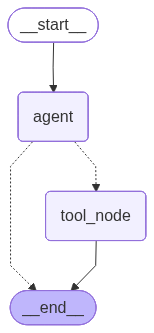

In [43]:
try:
  display(Image(app1.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [39]:
app1.invoke({"messages":["Hello"]})

[HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='99940466-7cb7-41a3-aea8-b650a8d870e8')]
Hello
content='Hello' additional_kwargs={} response_metadata={} id='99940466-7cb7-41a3-aea8-b650a8d870e8'
content='Hello! How can I help you today?' additional_kwargs={'reasoning_content': 'The user says "Hello". Likely a greeting. We should respond politely. Possibly ask what they need.'} response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 129, 'total_tokens': 170, 'completion_time': 0.064686754, 'completion_tokens_details': {'reasoning_tokens': 23}, 'prompt_time': 0.0071797, 'prompt_tokens_details': None, 'queue_time': 0.026078722, 'total_time': 0.071866454}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_84bb35977d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019bbb99-fc39-7932-823a-6acc3a3acb4c-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_toke

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='99940466-7cb7-41a3-aea8-b650a8d870e8'),
  AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'The user says "Hello". Likely a greeting. We should respond politely. Possibly ask what they need.'}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 129, 'total_tokens': 170, 'completion_time': 0.064686754, 'completion_tokens_details': {'reasoning_tokens': 23}, 'prompt_time': 0.0071797, 'prompt_tokens_details': None, 'queue_time': 0.026078722, 'total_time': 0.071866454}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_84bb35977d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bbb99-fc39-7932-823a-6acc3a3acb4c-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 129, 'output_tokens': 41, 'total_tokens': 170, 'output_token_details':

In [ ]:
app1.invoke({"messages":["How is the weather in USA?"]})

content='' additional_kwargs={'reasoning_content': 'The user asks: "How is the weather in USA?" They want weather info. We need to use the provided function search with query "weather in USA" or similar. Probably we should call the search function.', 'tool_calls': [{'id': 'fc_0c939e7a-f7f0-4614-9be7-ab7dd12fa5e0', 'function': {'arguments': '{"query":"weather in USA"}', 'name': 'search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 130, 'total_tokens': 198, 'completion_time': 0.079033143, 'completion_tokens_details': {'reasoning_tokens': 44}, 'prompt_time': 0.008412319, 'prompt_tokens_details': None, 'queue_time': 0.508076076, 'total_time': 0.087445462}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_334cc21c60', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019bb818-618e-7ab3-8b4c-c46be1131717-0' tool_calls=[{'name': 'search', 'args': {'query': 'we

{'messages': [HumanMessage(content='How is the weather in USA?', additional_kwargs={}, response_metadata={}, id='aad8fb90-4193-42f2-b81d-a4a4b014cd24'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "How is the weather in USA?" They want weather info. We need to use the provided function search with query "weather in USA" or similar. Probably we should call the search function.', 'tool_calls': [{'id': 'fc_0c939e7a-f7f0-4614-9be7-ab7dd12fa5e0', 'function': {'arguments': '{"query":"weather in USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 130, 'total_tokens': 198, 'completion_time': 0.079033143, 'completion_tokens_details': {'reasoning_tokens': 44}, 'prompt_time': 0.008412319, 'prompt_tokens_details': None, 'queue_time': 0.508076076, 'total_time': 0.087445462}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_334cc21c60', 'service_tier': 'on_demand', 'finish_reas

{'messages': [HumanMessage(content='How is the weather in USA?', additional_kwargs={}, response_metadata={}, id='695d05aa-af45-4d65-9b3a-295d272b1371'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "How is the weather in USA?" They want a weather overview. Likely need to use the search function. The tool search can provide info about weather. We can search for "weather in USA".', 'tool_calls': [{'id': 'fc_68d696d7-4473-4468-9f57-d6cb2e72dcf5', 'function': {'arguments': '{"query":"weather in USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 130, 'total_tokens': 199, 'completion_time': 0.094287349, 'completion_tokens_details': {'reasoning_tokens': 45}, 'prompt_time': 0.00822728, 'prompt_tokens_details': None, 'queue_time': 0.451171697, 'total_time': 0.102514629}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_1074f9ce08', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bb814-3144-7dc2-9c9c-a5283be943b1-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in USA'}, 'id': 'fc_68d696d7-4473-4468-9f57-d6cb2e72dcf5', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 130, 'output_tokens': 69, 'total_tokens': 199, 'output_token_details': {'reasoning': 45}})]}

## Agent with the tools and cycle between tools and agents

In [5]:
from langchain_groq import ChatGroq
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph, MessagesState, START, END , add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from IPython.display import Image, display
from typing import TypedDict, Annotated, Literal

In [4]:
llm=ChatGroq(model="openai/gpt-oss-20b", api_key=api_key)

In [6]:
@tool
def search(query:str):
  """This is the tools that will give the weather report of any country or cities"""
  if 'nepal' in query.lower() or 'np' in query.lower():
    return "The weather is 20 degree celceius at day and 10 degree at night"
  else:
    return "The weather is 25 degree celceius at day and 15 degree at night"


In [9]:
tools=[search]

In [10]:
llm_with_tools=llm.bind_tools(tools)

In [13]:
tool_node=ToolNode(tools=tools)

In [11]:
class MessagesState(TypedDict):
  messages:Annotated[list[AnyMessage], add_messages]


In [91]:
def agent(state:MessagesState):
  message=state["messages"]
  print(message)
  print("final one-----")
  print(message[-1])
  response=llm_with_tools.invoke(message)
  return {"messages":[response]}



In [85]:
def router(state:MessagesState)->Literal["tool_node",END]:
  message=state["messages"][-1]
  print("From the router")
  print(message)
  ai_message=message.additional_kwargs
  ai_message=ai_message.get("reasoning_content")
  print(ai_message)
  if message.tool_calls:
    return "tool_node"
  else:
    return END

In [86]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [87]:
workflow3=StateGraph(MessagesState)
workflow3.add_node("agent",agent)
workflow3.add_node("tool_node",tool_node)
workflow3.add_conditional_edges("agent",router,{"tool_node":"tool_node",END:END})
workflow3.add_edge(START,"agent")
workflow3.add_edge("tool_node","agent")
app3=workflow3.compile(checkpointer=memory)

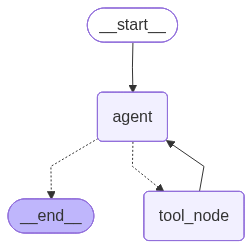

In [88]:
try:
  display(Image(app3.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [89]:
config={"configurable":{"thread_id":"3"}}

In [90]:
while True:
  query=input("Enter your query or else enter break to stop:")
  if query.lower()== "break":
    break
  else:
    events=app3.stream({"messages":[f"{query}"]},config=config,stream_mode="values")
    for event in events:
      event["messages"][-1].pretty_print()



Enter your query or else enter break to stop:helo
================================ Human Message =================================

helo
[HumanMessage(content='helo', additional_kwargs={}, response_metadata={}, id='b14a5c75-d08d-4426-9a31-04e82556f603')]
final one-----
content='helo' additional_kwargs={} response_metadata={} id='b14a5c75-d08d-4426-9a31-04e82556f603'
From the router
content='Hello! 👋 How can I help you today?' additional_kwargs={'reasoning_content': 'User says "helo". Likely greeting. We should respond politely.'} response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 129, 'total_tokens': 164, 'completion_time': 0.040589877, 'completion_tokens_details': {'reasoning_tokens': 15}, 'prompt_time': 0.008287248, 'prompt_tokens_details': None, 'queue_time': 0.110070395, 'total_time': 0.048877125}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_d23c14756c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provid